In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:  Adile Gündoğdu ( Istanbul Technical University)
#   E-mail: adilegundogdu34@gmail.com
#   Edited by:  Margaret Duff (STFC)

# Showcase of the algorithms for deblurring and denoising

In this notebook, we are going to investigate the Total Variation Algorithms, Gradient Descent and FISTA on cases with 2 types of noises. Firstly, we build an inverse problem; thus, we will blur the image and then add noise. Next, we will try to fix the picture we've distorted and finally, we will compare the results. 

If you have any questions, please do not hesitate to contact with me! 



## Import algorithms, operators and functions <a class="anchor" id="chapter1"></a>
First, we import all tools needed:

In [2]:
# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator, BlurringOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, \
                                       ZeroFunction
from cil.utilities import  noise

# Import data examples 

from cil.utilities import dataexample


# Import CIL Processors for preprocessing
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter

# Import CIL display function
from cil.utilities.display import show2D


# Import FBP from CIL recon class
from cil.recon import FBP

#Import Total Variation from the regularisation toolkit plugin
from cil.plugins.ccpi_regularisation.functions import FGP_TV

from cil.framework import ImageGeometry, ImageData

# All external imports
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.image as mpimg


### CIL Version 23.0.1

In [3]:
import cil
print(cil.__version__)

23.0.1


## Setting up the direct problem <a class="anchor" id="chapter2"></a>

We choose a CIL example image:

In [4]:

im_gray_cil = dataexample.BOAT.get((225,225))
print(im_gray_cil)
ig=im_gray_cil.geometry 

Number of dimensions: 2
Shape: (225, 225)
Axis labels: ('horizontal_y', 'horizontal_x')



 We need to define a plotting function for the use same range and size all the time.

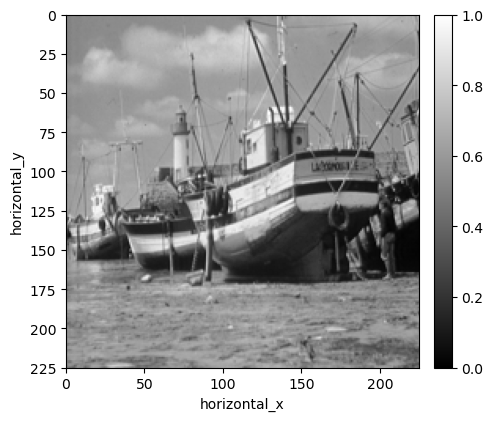

In [5]:
myshow = lambda image : show2D(image, origin="upper", size=(8,8), fix_range=(0,1))
myshow(im_gray_cil)

## The Deblurring Inverse Problem <a class="anchor" id="section_2_1"></a>

We consider the deblurring problem

$$ d = A u + \eta$$

where 
- $u$ is the unknown sharp image
- $A$ is a linear operator representing blurring
- $\eta$ is additive Gaussian noise
- $d$ is the blurred and noisy image.

To set up the direct problem we specify a *point spread function (PSF)* to blur the image through a convolution:

In [6]:
# Parameters for point spread function PSF (size and std)
ks          = 5
ksigma      = 2

# Create 1D PSF and 2D as outer product, then normalise.
w           = np.exp(-np.arange(-(ks-1)/2,(ks-1)/2+1)**2/(2*ksigma**2))
w.shape     = (ks,1)
PSF         = w*np.transpose(w)
PSF         = PSF/(PSF**2).sum()
PSF         = PSF/PSF.sum()

For the blurring, CIL has a specify Blurring Operator and we use it, then we apply it to the test image and display it.

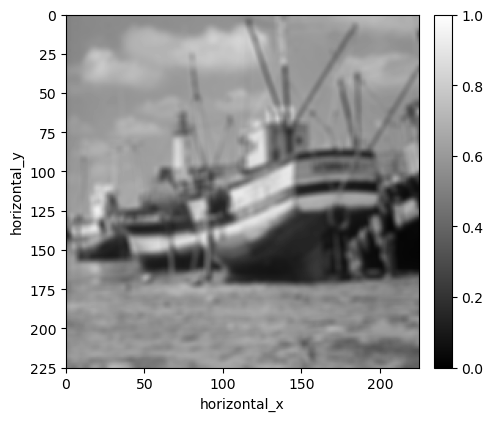

In [7]:
A = BlurringOperator(PSF, ig)
im_blur = A.direct(im_gray_cil)
myshow(im_blur)

For the denoising part of this problem, we want to compare the different noises and their results. So, we add Gaussian and Salt-and-Pepper noise.

## Different Noise: Gaussian Noise <a class="anchor" id="sub_section_2_2_1"></a>

We add Gaussian noise to the blurred image.

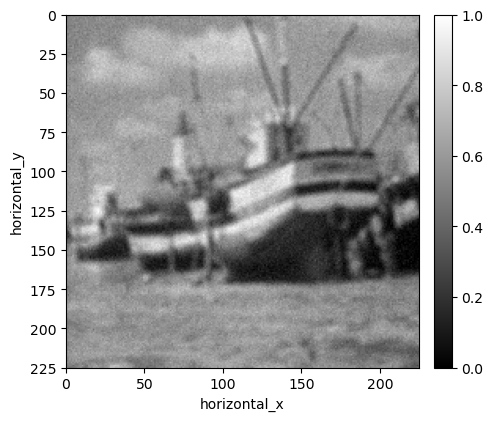

In [8]:
im_blur_noise_gaussian = noise.gaussian(im_blur, seed=10, var=0.001)
myshow(im_blur_noise_gaussian)

### Variational regularisation

We formulate the image deblurring problem as an optimization problem to simultaneously fit to the data and enforce regularization on the solution. We use a simple least squares data-fitting term with the blurring operator and try out a few different regularizers $\Psi(u)$ in the general form optimization problem: 

$$
\min_u  \| A u - d\|^{2}_{2} + \alpha\,\Psi(u)
$$



#### Gradient Descent  <a class="anchor" id="sub_sub_section_2_2_1_3"></a>

The choice of $\Psi(u)$ determines the regularization to apply. We first try without regularization, $\Psi(u) = 0$, leaving us with the simpler least-squares optimization problem
$$
\min_u  \| A u - d\|^{2}_{2}
$$

We set up a *LeastSquares* function object(F):

In [9]:
F = LeastSquares(A, im_blur_noise_gaussian)
x0 = ig.allocate(0.0)

You can visualise the calculated gradients: 

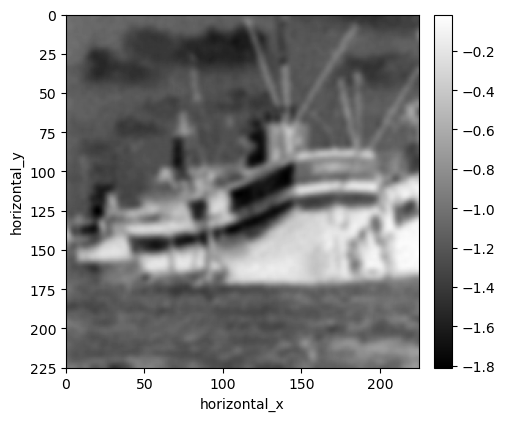

In [10]:
s_x = 50
s_y = 60
slices = [('horizontal_x',s_x),('vertical',s_y)]

show2D(F.gradient(x0),slice_list=slices,origin='upper-left',  size=(8,8))

We now run gradient descent: 

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.56076e+04
       50       1000         0.012          3.67519e+01
      100       1000         0.011          3.29310e+01
      150       1000         0.011          3.07064e+01
      200       1000         0.011          2.91941e+01
      250       1000         0.011          2.80672e+01
      300       1000         0.011          2.71755e+01
-------------------------------------------------------
      300       1000         0.011          2.71755e+01
Stop criterion has been reached.



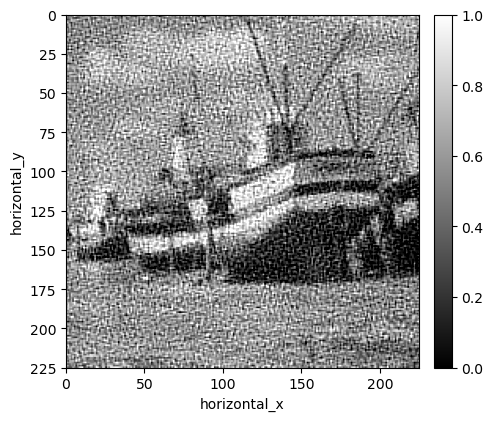

In [11]:

myGD_LS = GD(initial=x0, 
             objective_function=F, 
             step_size=None, 
             max_iteration=1000, 
             update_objective_interval=50)

myGD_LS.run(300, verbose=1)

myshow(myGD_LS.solution)

Reconstructing the blurred image is an ill-posed inverse problem, and we see that the solution has become unstable with the added noise in the observed data. Looking at the solution over the full range of values we see that the reconstruction has some values outside the expected range: 

In [12]:
print(' The range of the solution is ', np.min(myGD_LS.solution), np.max(myGD_LS.solution))

 The range of the solution is  -0.51695734 1.5081458


### Using FISTA to add an indicator function to the objective

With FISTA, we can solve the least squares problem and in addition we can add the extra condition that the reconstructed values should be bounded below by zero and above by 1 and this improves the reconstruction: 

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     


        0       1000         0.000          1.56076e+04
       50       1000         0.050          2.70418e+01
      100       1000         0.054          2.42223e+01
      150       1000         0.051          2.37390e+01
      200       1000         0.051          2.36360e+01
      250       1000         0.050          2.36093e+01
      300       1000         0.048          2.36002e+01
-------------------------------------------------------
      300       1000         0.048          2.36002e+01
Stop criterion has been reached.



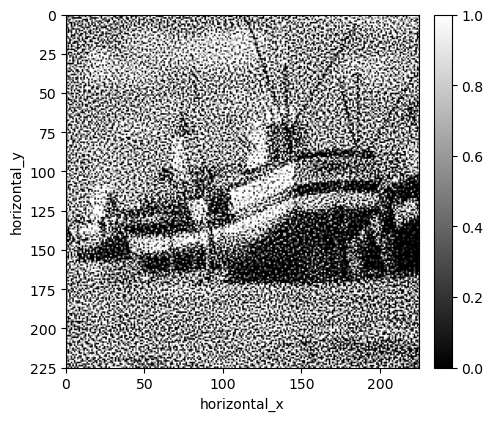

 The range of the solution is  0.0 1.0


In [13]:
x0 = ig.allocate(0.0)
F = LeastSquares(A, im_blur_noise_gaussian)
G = IndicatorBox(lower=0.0, upper=1.0)
myFISTANN = FISTA(f=F, 
                  g=G, 
                  initial=x0, 
                  max_iteration=1000,
                  update_objective_interval = 50)

myFISTANN.run(300, verbose=1)

myshow(myFISTANN.solution)
print(' The range of the solution is ', np.min(myFISTANN.solution), np.max(myFISTANN.solution))



The range is now correct but the solution is still sensitive to the noise in the data. We can now try different regularisers. 

### GGLS with regularisation 

Using CGLS to solve the Tikhonov problem with gradient operator D, i.e.,  
$$\min_u \|Au-b\|_2^2 + \alpha^2\|Du\|_2^2$$

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.56076e+04


       30       1000         0.016          1.74882e+02
       60       1000         0.015          1.74717e+02
-------------------------------------------------------
       75       1000         0.015                     
Stop criterion has been reached.



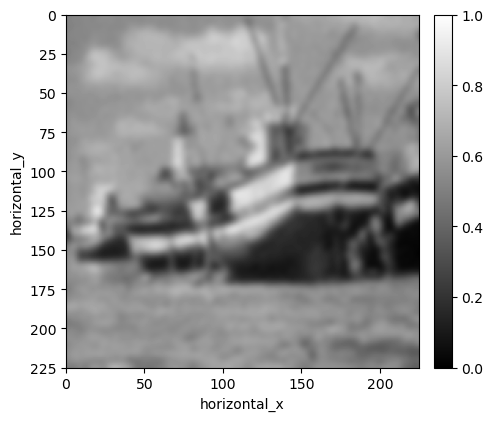

In [14]:
F = LeastSquares(A, im_blur_noise_gaussian)
D = GradientOperator(ig, backend = 'numpy')
alpha = 1.5
F_reg = OperatorCompositionFunction(L2NormSquared(),D)
Full = F + (alpha**2)*F_reg

myGD_tikh = GD(initial=x0, 
               objective_function=Full, 
               step_size=None, 
               max_iteration=1000, 
               update_objective_interval = 30)
myGD_tikh.run(75, verbose=1)

myshow(myGD_tikh.solution)

#### Total variation deblurring  <a class="anchor" id="sub_sub_section_2_2_1_1"></a>

The solution is blurry and we have lost all sharp edges and so we try Total Variation regularisation. 
We will try to solve this minimization problem.

$$\begin{equation}
\underset{u}{\operatorname{argmin}} \frac{1}{2} \| A u - g\|^{2}_{2} + \alpha\,\mathrm{TV}(u)
\end{equation}$$

where,

* g is a noisy data corrupted with Gaussian noise,
* $A$ is a Blurring operator,
* TV stands for the Total variation regulariser.


Once set up, we can then run it for some iterations and inspect the preliminary resulting image:

In [15]:
alpha = 0.01
G = alpha * TotalVariation(max_iteration=10, backend='numpy')
F = LeastSquares(A, im_blur_noise_gaussian)

deblur_TV = FISTA(initial = ig.allocate(0), f = F, g = G, 
              max_iteration = 200, update_objective_interval = 50)
deblur_TV.run()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          1.56076e+04
       50        200         0.312          6.26944e+01
      100        200         0.316          6.26940e+01
      150        200         0.314          6.26940e+01
      200        200         0.317          6.26940e+01
-------------------------------------------------------
      200        200         0.317          6.26940e+01
Stop criterion has been reached.



We clearly see that TV deblurring works on the blurred image very well even if there is added noise.
 

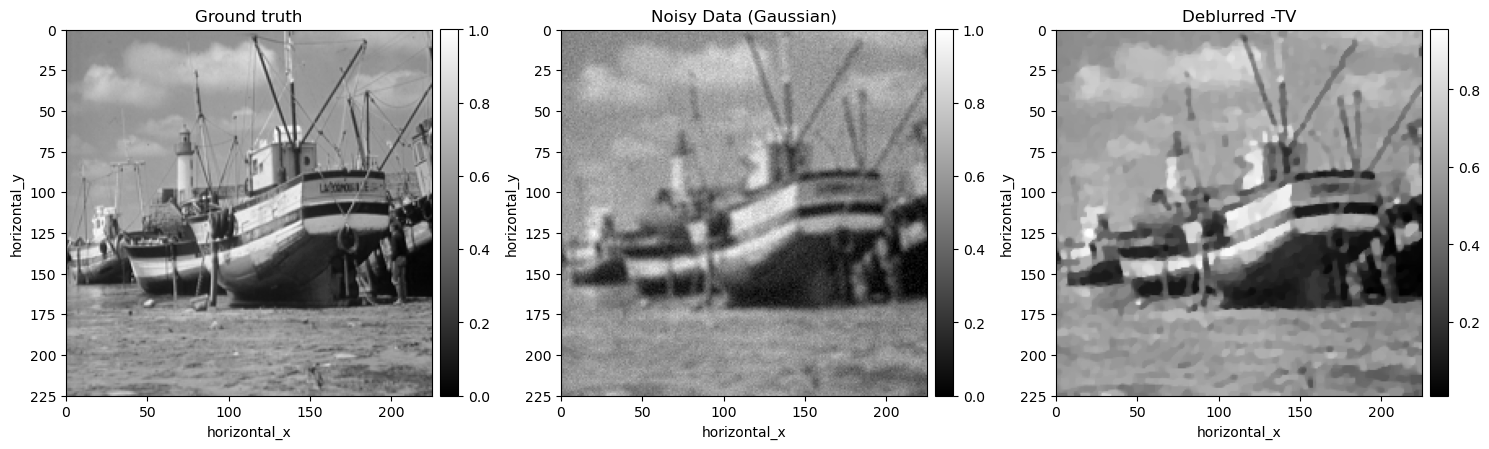

In [16]:
show2D([im_gray_cil, im_blur_noise_gaussian, deblur_TV.solution], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Deblurred -TV'], 
       origin="upper", num_cols=3)

#### The results

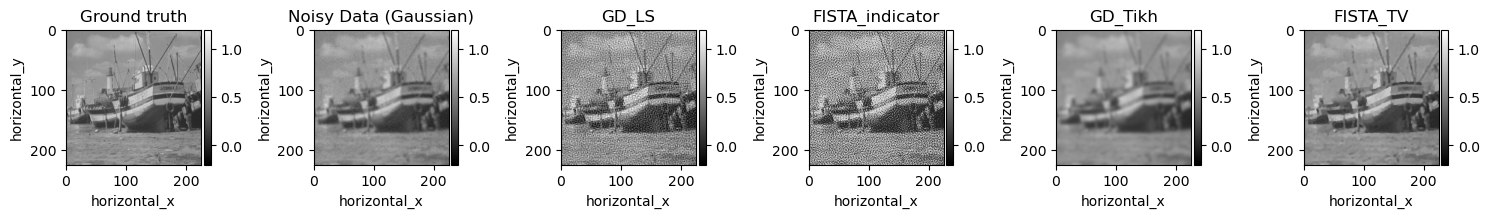

In [17]:
show2D([im_gray_cil, im_blur_noise_gaussian, myGD_LS.solution, myFISTANN.solution, myGD_tikh.solution,  deblur_TV.solution], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'GD_LS', 'FISTA_indicator',  'GD_Tikh', 'FISTA_TV'], 
       origin="upper", num_cols=6, fix_range =(-0.2,1.2))

## Different Noises: Salt and Pepper Noise  <a class="anchor" id="sub_section_2_2_2"></a> 

Now, we use another noise which is Salt-and-Pepper noise.

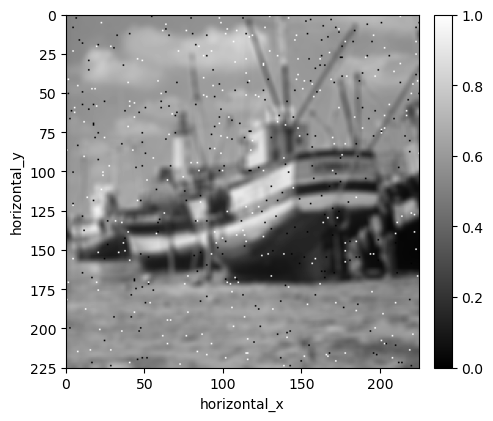

In [18]:
im_blur_noise_saltnpepper = noise.saltnpepper(im_blur, amount=0.01, seed = 10)
myshow(im_blur_noise_saltnpepper)

#### Total variation deblurring  <a class="anchor" id="sub_sub_section_2_2_2_1"></a>

We try Total Variation denoising again for different values of the regularisation parameter $\alpha$. 

If the regularisation parameter is too small, the solution converges to the least squares solution. For example, if  $\alpha$ is 0.001, then the result is divergent:

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          1.56462e+04
       50        200         0.337          7.43907e+01
      100        200         0.341          6.11240e+01
      150        200         0.334          5.40769e+01
      200        200         0.321          4.97718e+01
-------------------------------------------------------
      200        200         0.321          4.97718e+01
Stop criterion has been reached.



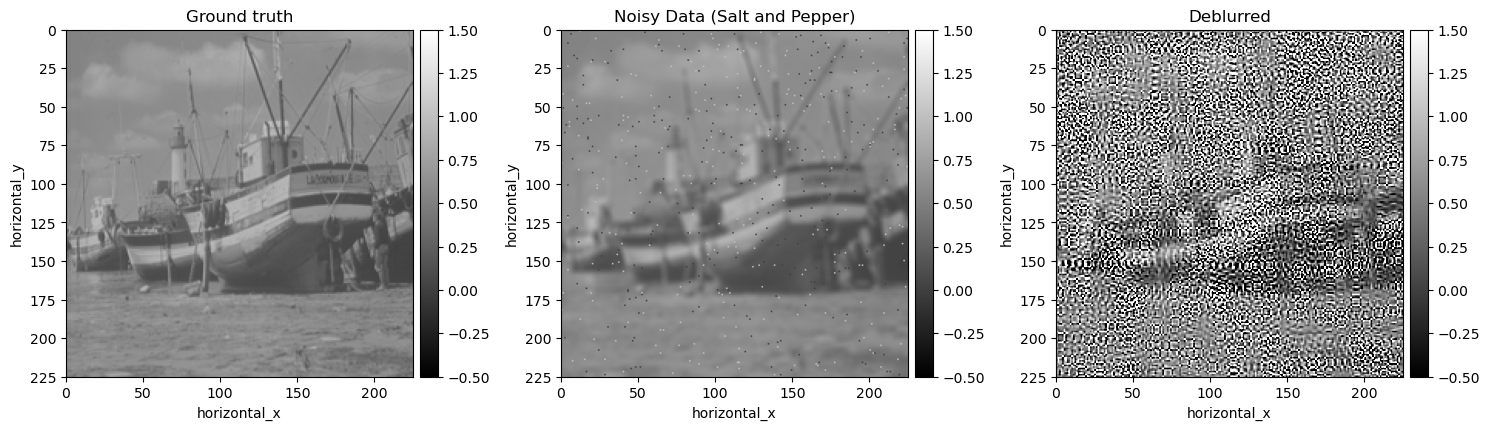

In [19]:
alpha = 0.0001
G = alpha * TotalVariation(max_iteration=10, backend='numpy')
F = LeastSquares(A, im_blur_noise_saltnpepper)

fista_saltnpepper_small = FISTA(initial = ig.allocate(0), f = F, g = G, 
              max_iteration = 200, update_objective_interval = 50)
fista_saltnpepper_small.run()

show2D([im_gray_cil, im_blur_noise_saltnpepper, fista_saltnpepper_small.solution], 
       title=['Ground truth', 'Noisy Data (Salt and Pepper)', 'Deblurred'], 
       origin="upper", num_cols=3, fix_range= (-0.5,1.5))

If the regularisation parameter is too large, the solution is overly cartoonish and blurry:

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          1.56462e+04


       50        200         0.288          2.59121e+02
      100        200         0.285          2.59122e+02
      150        200         0.294          2.59122e+02
      200        200         0.305          2.59122e+02
-------------------------------------------------------
      200        200         0.305          2.59122e+02
Stop criterion has been reached.



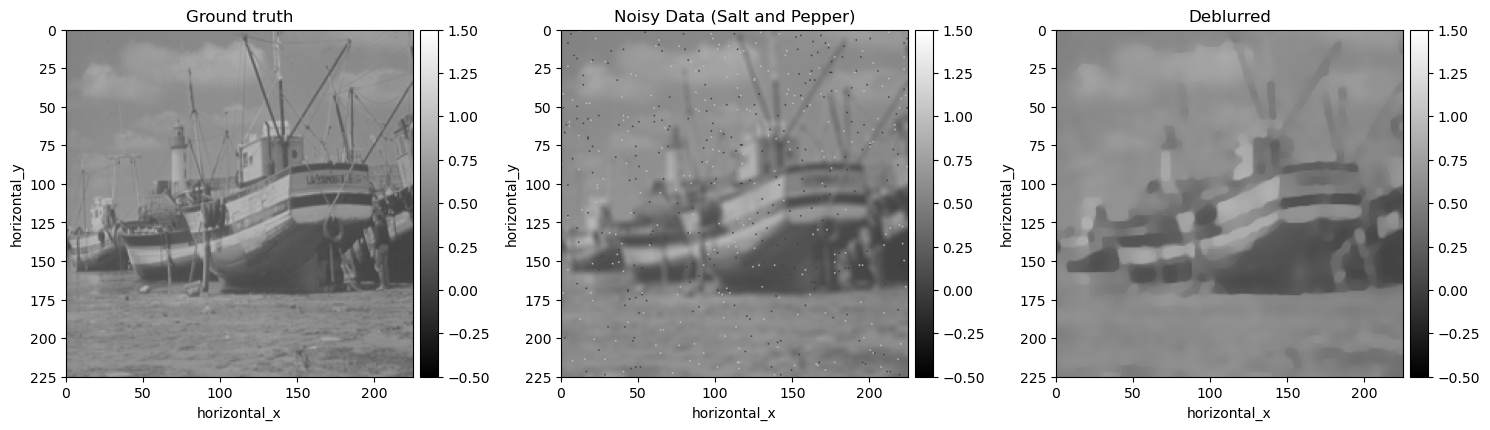

In [20]:
alpha = 0.1
G = alpha * TotalVariation(max_iteration=10, backend='numpy')
F = LeastSquares(A, im_blur_noise_saltnpepper)

fista_saltnpepper_large= FISTA(initial = ig.allocate(0), f = F, g = G, 
              max_iteration = 200, update_objective_interval = 50)
fista_saltnpepper_large.run()

show2D([im_gray_cil, im_blur_noise_saltnpepper, fista_saltnpepper_large.solution], 
       title=['Ground truth', 'Noisy Data (Salt and Pepper)', 'Deblurred'], 
       origin="upper", num_cols=3, fix_range= (-0.5,1.5))

A middle regularisation parameter is still struggling with the salt and pepper noise

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          1.56462e+04


       50        200         0.318          1.42820e+02
      100        200         0.338          1.42818e+02
      150        200         0.343          1.42818e+02
      200        200         0.324          1.42818e+02
-------------------------------------------------------
      200        200         0.324          1.42818e+02
Stop criterion has been reached.



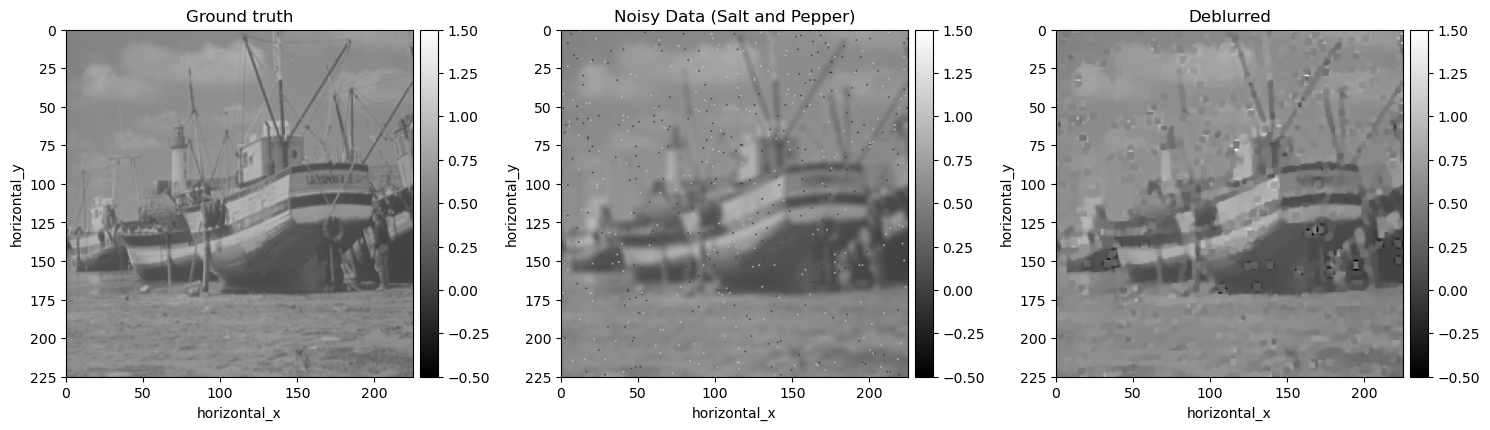

In [21]:
alpha = 0.01
G = alpha * TotalVariation(max_iteration=10, backend='numpy')
F = LeastSquares(A, im_blur_noise_saltnpepper)

fista_saltnpepper_middle = FISTA(initial = ig.allocate(0), f = F, g = G, 
              max_iteration = 200, update_objective_interval = 50)
fista_saltnpepper_middle.run()

show2D([im_gray_cil, im_blur_noise_saltnpepper, fista_saltnpepper_middle.solution], 
       title=['Ground truth', 'Noisy Data (Salt and Pepper)', 'Deblurred'], 
       origin="upper", num_cols=3, fix_range= (-0.5,1.5))

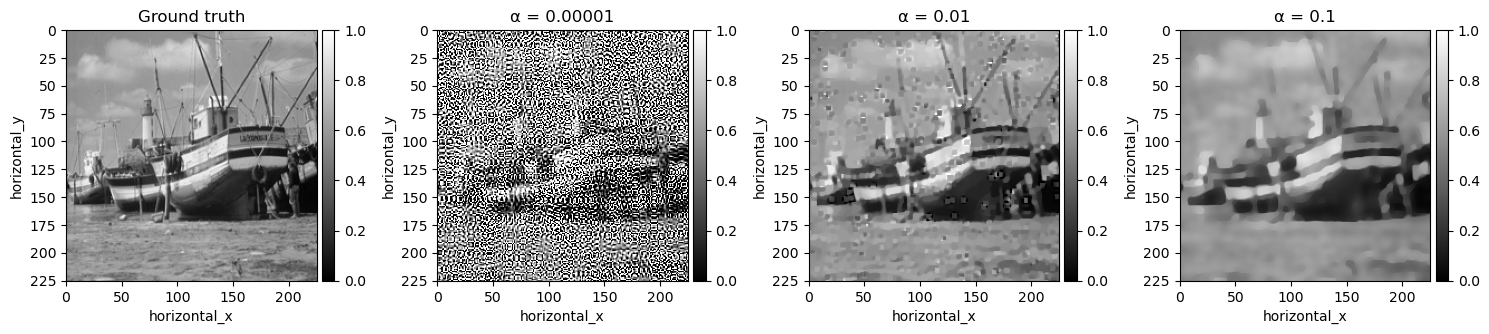

In [22]:
show2D([im_gray_cil,fista_saltnpepper_small.solution, fista_saltnpepper_middle.solution, fista_saltnpepper_large.solution], 
       title=['Ground truth', '\u03B1 = 0.00001','\u03B1 = 0.01', '\u03B1 = 0.1'], 
       origin="upper", num_cols=4, fix_range = (0,1))

## Denoising and deblurring without knowledge of the blur kernel  <a class="anchor" id="chapter3"></a>

Consider the case where you did not know the blur kernel (or that the image was blurred), and just attempt to remove the noise in the image. One could consider: 

$$\begin{equation}
\underset{u}{\operatorname{argmin}} \frac{1}{2} \| u - g\|^{2}_{2} + \alpha \mathrm{TV}(u)
\end{equation}$$

where,

* g is a noisy data corrupted with Gaussian noise,
* TV stands for the Total variation regulariser.
* $\alpha$ is penalty.

Consider a range of different $\alpha$:

When $\alpha$ is so small;

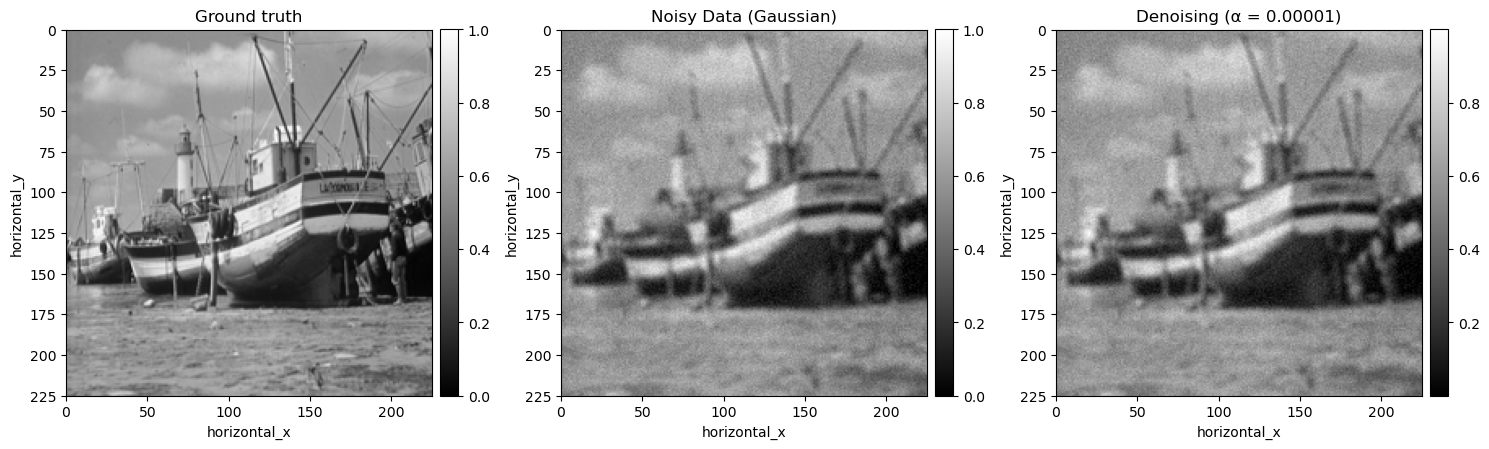

In [23]:
alpha = 0.00001
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV_1 = TV.proximal(im_blur_noise_gaussian, tau=1)

show2D([im_gray_cil, im_blur_noise_gaussian, proxTV_1], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Denoising (\u03B1 = 0.00001)'], 
       origin="upper", num_cols=3)

       


When $\alpha$ is small;


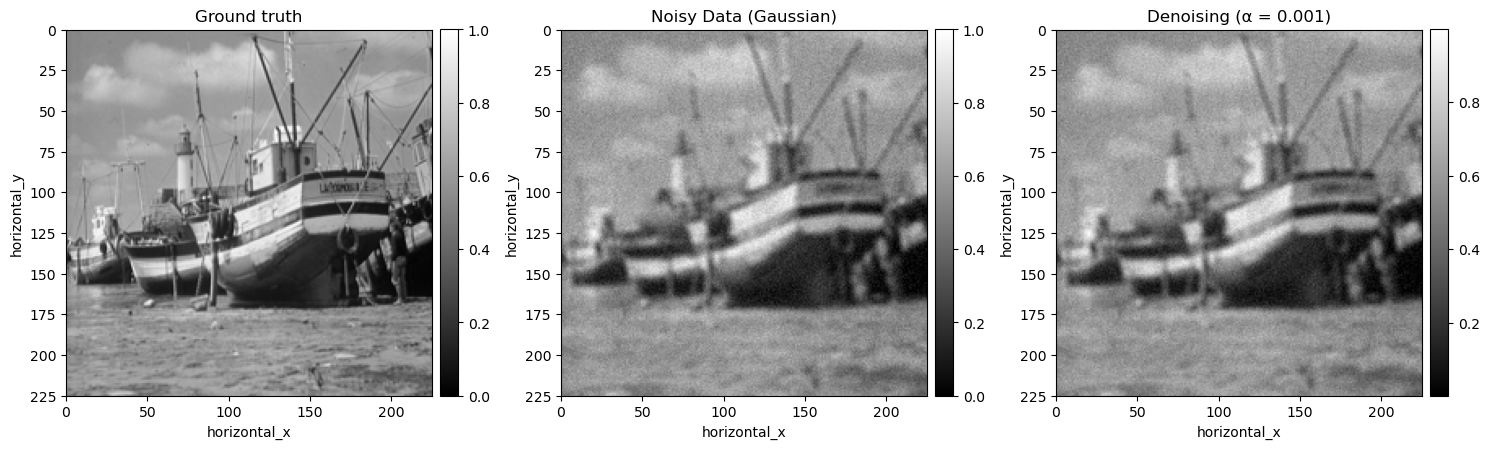

In [24]:

alpha = 0.001
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV_2 = TV.proximal(im_blur_noise_gaussian, tau=1.0)

show2D([im_gray_cil, im_blur_noise_gaussian, proxTV_2], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Denoising (\u03B1 = 0.001)'], 
       origin="upper", num_cols=3)
       


When $\alpha$ is (somewhat) optimal;


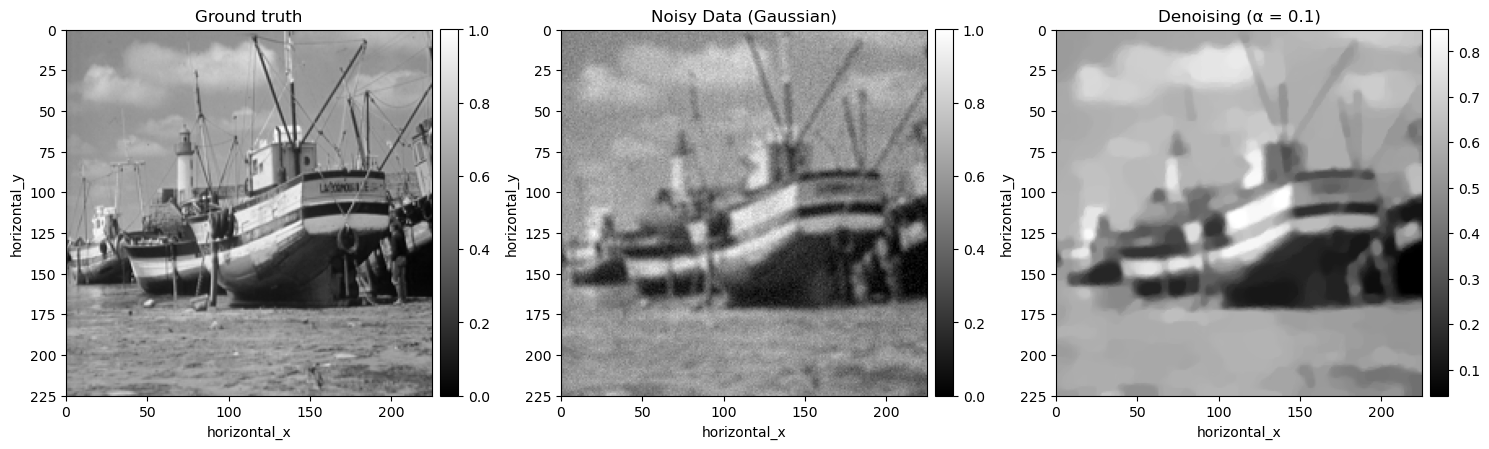

In [25]:

alpha = 0.1
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV_3 = TV.proximal(im_blur_noise_gaussian, tau=1)

show2D([im_gray_cil, im_blur_noise_gaussian, proxTV_3], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Denoising (\u03B1 = 0.1)'], 
       origin="upper", num_cols=3)
       


When $\alpha$ is big;


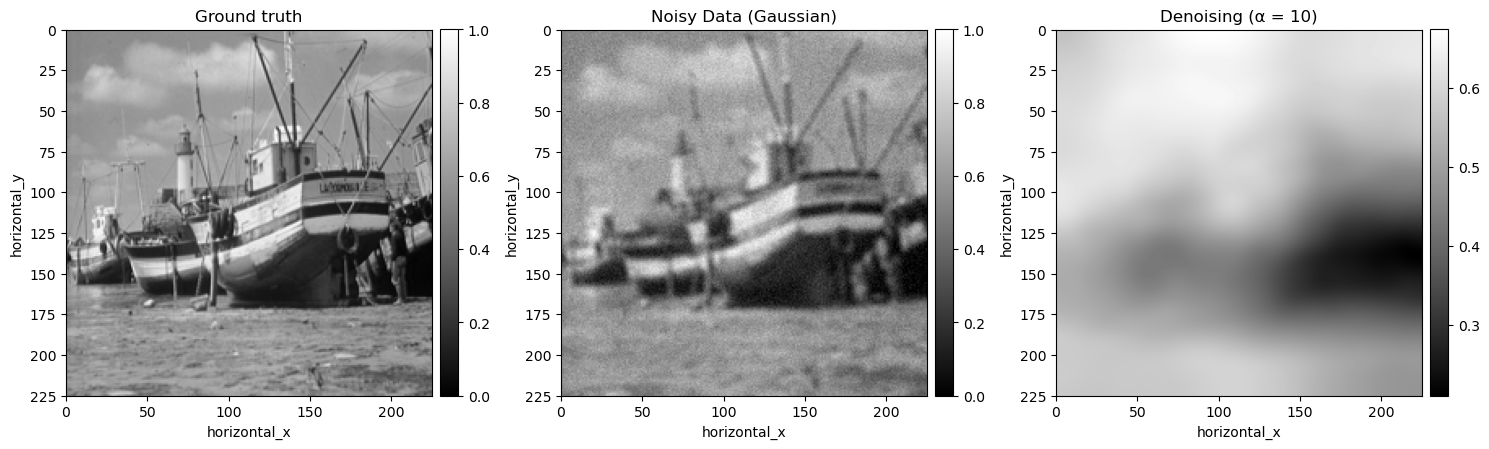

In [26]:

alpha = 10
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV_4 = TV.proximal(im_blur_noise_gaussian, tau=1)

show2D([im_gray_cil, im_blur_noise_gaussian, proxTV_4], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Denoising (\u03B1 = 10)'], 
       origin="upper", num_cols=3)
       


When $\alpha$ is so big;


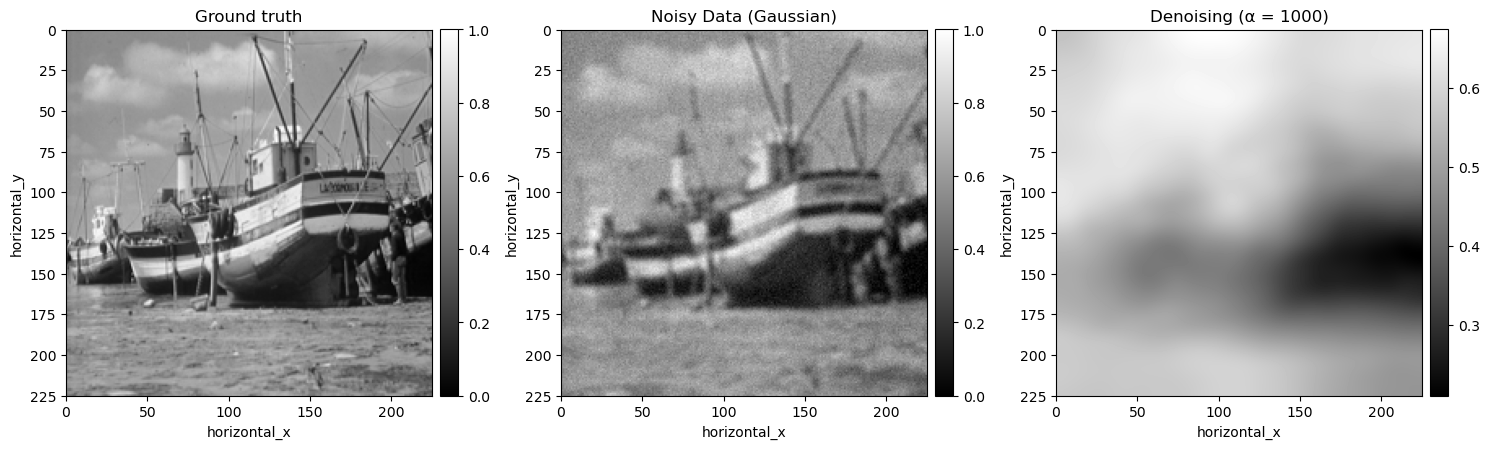

In [27]:

alpha = 1000
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV_5 = TV.proximal(im_blur_noise_gaussian, tau=1)

show2D([im_gray_cil, im_blur_noise_gaussian, proxTV_5], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Denoising (\u03B1 = 1000)'], 
       origin="upper", num_cols=3)
       


Overall, we can see that when $\alpha$ is big, all the details and lines disappear. However, when $\alpha$ is small, noise doesn't disappear.


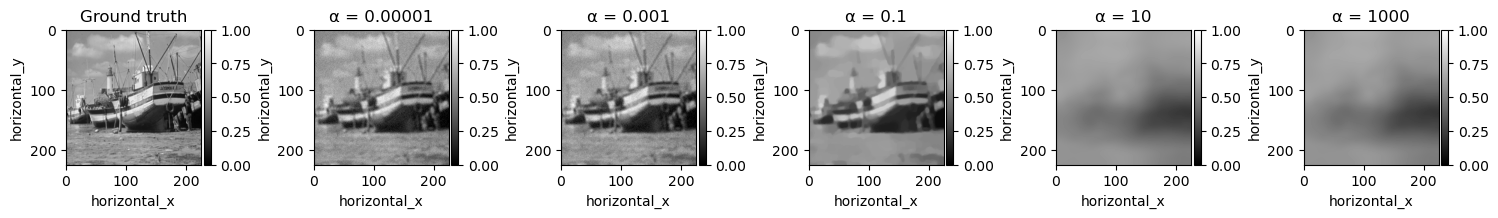

In [28]:

show2D([im_gray_cil,proxTV_1, proxTV_2, proxTV_3, proxTV_4, proxTV_5], 
       title=['Ground truth', '\u03B1 = 0.00001','\u03B1 = 0.001', '\u03B1 = 0.1', '\u03B1 = 10', '\u03B1 = 1000'], 
       origin="upper", num_cols=6, fix_range = (0,1))

## Deblurring without noise in the data  <a class="anchor" id="chapter4"></a>

I will try the TV denoising algorithm only with blurred image (no added noise): 

In [29]:
# Parameters for point spread function PSF (size and std)
ks          = 5
ksigma      = 2

# Create 1D PSF and 2D as outer product, then normalise.
w           = np.exp(-np.arange(-(ks-1)/2,(ks-1)/2+1)**2/(2*ksigma**2))
w.shape     = (ks,1)
PSF         = w*np.transpose(w)
PSF         = PSF/(PSF**2).sum()
PSF         = PSF/PSF.sum()

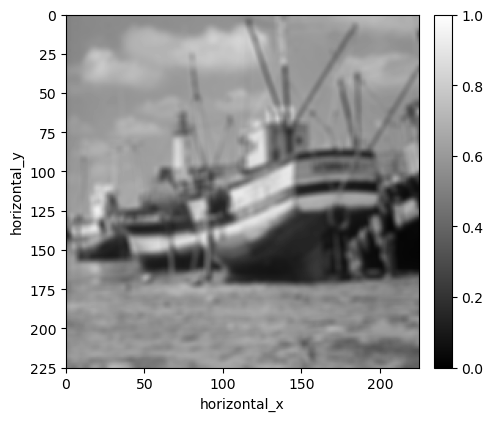

In [30]:
A = BlurringOperator(PSF, ig)
im_blur = A.direct(im_gray_cil)
myshow(im_blur)

In [31]:
alpha = 0.05
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV = TV.proximal(im_blur, tau=0.5)
#we can change tau and see the differences.

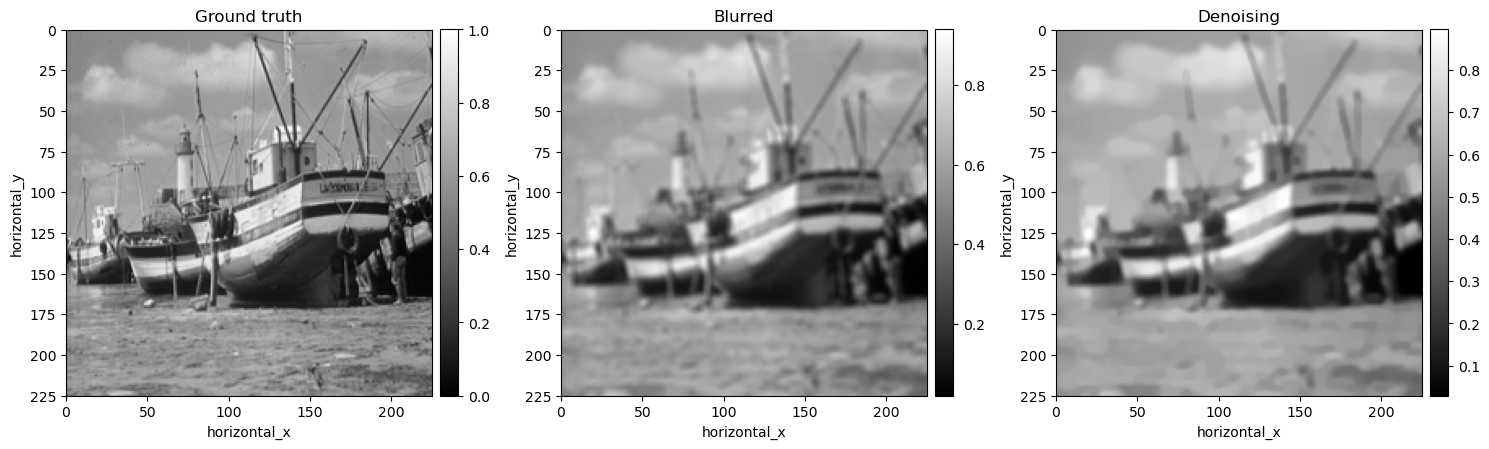

In [32]:
show2D([im_gray_cil, im_blur, proxTV], 
       title=['Ground truth', 'Blurred', 'Denoising'], 
       origin="upper", num_cols=3)